### Задача uplift-моделирования

### План занятия

* Введение: коммуникация с пользователями
* Дизайн эксперимента
* Типы клиентов
* Одна модель с дополнительным признаком
* Вариант с двумя независимыми моделями
* Вариант с двумя зависимыми моделями
* Прямой расчет uplift: "деревянные" модели
* Ссылки

### Введение

Часто возникает необходимость коммуникации с пользователями для продвижения сервисов и услуг.

Коммуникация осуществляется с помощью различных каналов: смс, звонки, push-уведомления, сообщения в чатботе и т.д

Например, мы хотим отправить push-уведомление игрокам в мобильной игре о том, что у них заполнились склады или об ином внутриигровом событии. Либо даже хотим отправить уведомление о наступающем внутриигровом эвенте (которые очень важны для активных игроков и для монетизации и развития игры в целом).

Другой пример:

Мы хотим прорекламировать популярный продукт, но при этом не хотим тратить бюджет на коммуникацию с пользователями, которые и без нас его купят. 

Изначально вопрос у нас такой: <b>Какова вероятность, что пользователь совершит нужное нам действие?</b>

Но нам нужен ответ не на него.

### Пример - задача прогнозирования оттока

Подробно задачу будем разбирать на следующем занятии, но давайте договоримся, что решать мы ее уже умеем.

Т.е мы для пользователей нашего сервиса можем посчитать вероятность ухода в отток.

![ab_split](churn.png "churn1")

Мы можем для пользователя определить вероятность:

P(User)

Мы хотим удерживать наших пользователей, которые чем-то недовольны или несчастны и хотим им предложить более выгодные условия подписки или тарифа (например, если мы - мобильный оператор, то мы можем предложить нашим абонентам более выгодный тариф).

Хорошо, мы можем отобрать из нашей аудитории наиболее "несчастных". Почему бы просто не сделать им предложение? В чем проблема? 

Проблема в том, что разные пользователи реагируют на коммуникацию по-разному и каждое взаимодействие стоит для нас денег.

И еще проблема - <b>наша модель неидеальна!</b>

#### Типы пользователей по реакции на коммуникацию

![ab_split](uplift_client_types.png "uplift_client_types")

1. Пользователи, которые совершат нужное действие независимо от коммуникации
2. Те, кто совершат действие, если будет коммуникация
3. Те, кто не совершит действие независимо от коммуникации
4. Не совершат действие, если коммуникация будет

Для оптимизации эффекта от воздействия хочется посчитать разницу реакций пользователя при наличии коммуникации и при ее отсутствии. 

Проблема в том, что мы не можем одновременно совершить коммуникацию и не совершить коммуникацию.

![ab_split](uplift2.png "uplift_cats")

Что же делать?

Необходимо оценить разницу между двумя событиями, которые являются взаимоисключающими для конкретного пользователя.

Для этого нам нужна обучающая выборка. А для нее нужно просто провести эксперимент. 

1. Берем часть базы пользователей и разбиваем на 2 группы: контрольную и экспериментальную
2. На экспериментальной группе запускаем маркетинговую кампанию (совершаем коммуникацию)
3. Через какое-то время у нас есть результаты совершения нужного действия клиентами в обеих группах (включая контрольную)
4. Проводим uplift-моделирование

![ab_split](uplift_3.png "uplift3")

![ab_split](uplift_scheme.png "uplift_scheme")

*взято из https://habr.com/ru/company/ru_mts/blog/485980/

### Пример модели с дополнительным признаком

Другие названия: Treatment Dummy approach, Solo model approach, Single model approach, S-Learner 

![ab_split](uplift_single_model.png "uplift_single_model")

### Две независимые модели

Другие названия: Two models approach, T-learner, difference two models

Интуитивно понятный и простой метод - моделируем 2 условные вероятности

1. обучаем модель прогноза вероятности совершения целевого действия для контрольной группы
2. обучаем модель прогноза вероятности совершения целевого действия для экспериментальной группы
3. на прогнозе - делаем прогноз для тестовых пользователей двумя моделями и вычитаем из прогноза второй модели прогноз первой

![ab_split](uplift_2models.png "uplift_2models")

p(y=1|w=1), p(y=1|w=0)

### Практический пример с соревнования X5 

http://retailhero.ai/#rec141268104

Импортируем нужные библиотеки и предобработаем данные:

In [20]:
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split


# Чтение данных
df_clients = pd.read_csv('clients.csv', index_col='client_id')
df_train = pd.read_csv('uplift_train.csv', index_col='client_id')
df_test = pd.read_csv('uplift_test.csv', index_col='client_id')

# Извлечение признаков
df_features = df_clients.copy()
df_features['first_issue_time'] = \
    (pd.to_datetime(df_features['first_issue_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['first_redeem_time'] = \
    (pd.to_datetime(df_features['first_redeem_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['issue_redeem_delay'] = df_features['first_redeem_time'] \
    - df_features['first_issue_time']
df_features = df_features.drop(['first_issue_date', 'first_redeem_date'], axis=1)

indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)

In [3]:
df_features.head()

,age,gender,first_issue_time,first_redeem_time,issue_redeem_delay
client_id,,,,,
000012768d,45,U,1501947648,1.515094e+09,13146559.0
000036f903,72,F,1491832463,1.492951e+09,1118613.0
000048b7a6,68,F,1544880791,NaN,NaN
000073194a,60,F,1495544174,1.511522e+09,15978107.0
00007c7133,67,U,1495469828,1.546277e+09,50806825.0


In [ ]:
df_test.head(3)

""
client_id
000048b7a6
000073194a
00007c7133


In [ ]:
df_train.groupby("treatment_flg")['target'].describe()

,count,mean,std,min,25%,50%,75%,max
treatment_flg,,,,,,,,
0,100058.0,0.603280,0.489219,0.0,0.0,1.0,1.0,1.0
1,99981.0,0.636511,0.481006,0.0,0.0,1.0,1.0,1.0


Заведем переменные

In [21]:
X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment_flg']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment_flg']

X_train_full = df_features.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment_flg']

X_test = df_features.loc[indices_test, :]

cat_features = ['gender']

models_results = {
    'approach': [],
    'uplift@30%': []
}

In [ ]:
X_train

,age,gender,first_issue_time,first_redeem_time,issue_redeem_delay
client_id,,,,,
ad6561e2d8,50,F,1512322431,1.527102e+09,14779510.0
7c1ccbf93f,24,F,1510331629,1.519326e+09,8994516.0
b58fadcab6,36,U,1509657465,1.537045e+09,27387871.0
e99e6fabb9,79,F,1526466080,1.527713e+09,1247284.0
27fb6f8520,34,F,1500320188,1.513332e+09,13012137.0
...,...,...,...,...,...
999d284453,72,U,1540991437,1.554559e+09,13567144.0
f634deea4e,35,U,1517752292,1.520877e+09,3124210.0
16cb4f99b0,50,F,1519380153,1.559324e+09,39944103.0


### 1. Подходы с одной моделью
#### 1.1 Одна модель с признаком коммуникации
Самое простое и интуитивное решение: модель обучается одновременно на двух группах, при этом бинарный флаг коммуникации выступает в качестве дополнительного признака. Каждый объект из тестовой выборки скорим дважды: с флагом коммуникации равным 1 и равным 0. Вычитая вероятности по каждому наблюдению, получим искомы uplift.

![ab_split](uplift4.png "uplift4")

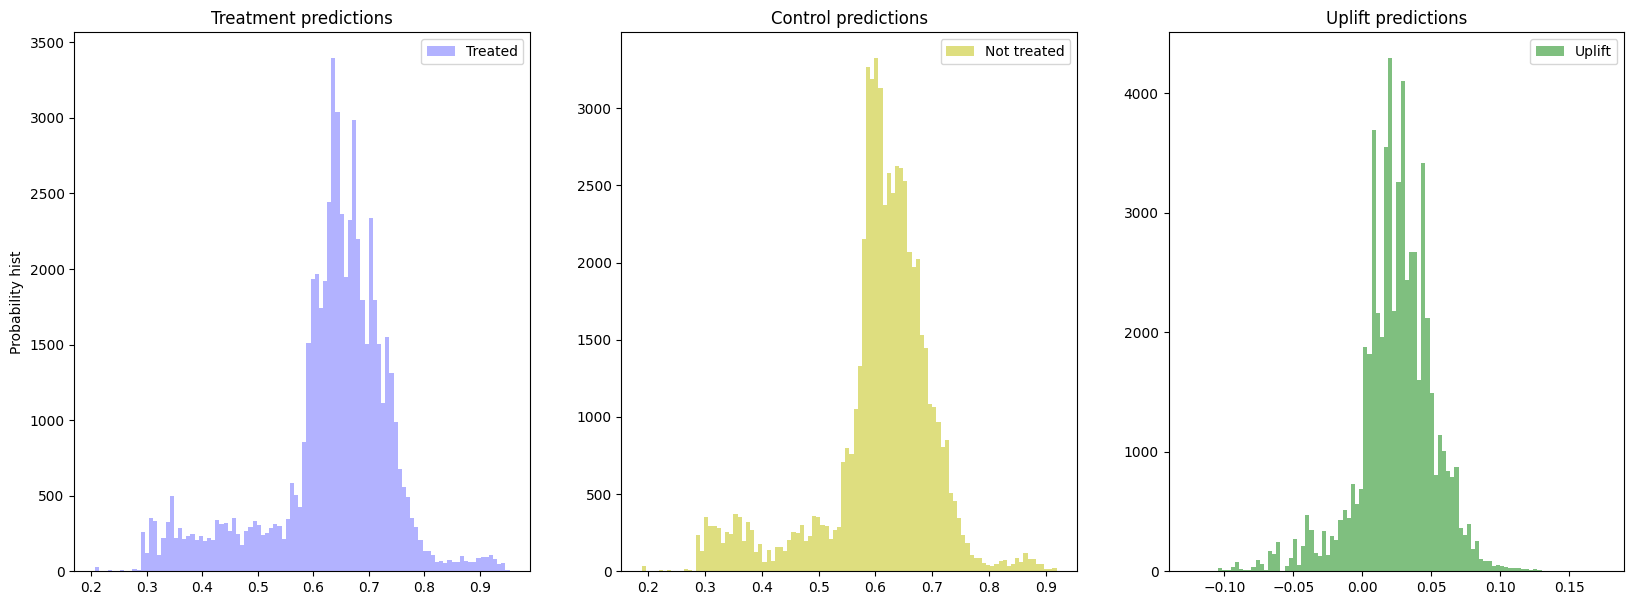

In [22]:
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

Посмотрим на топ-признаки

In [ ]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,first_redeem_time,41.162563
1,issue_redeem_delay,38.676225
2,age,8.003793
3,first_issue_time,6.274424
4,treatment,3.431789
5,gender,2.451207


#### 1.2 Трансформация классов
Достаточно интересный и математически подтвержденный подход к построению модели, представленный еще в 2012 году. Метод заключается в прогнозировании немного измененного таргета:

![ab_split](uplift5.png "uplift5")

![ab_split](uplift_client_types.png "uplift_client_types")

In [23]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

#### 2.1 Две независимые модели
Как понятно из названия, подход заключается в моделировании условных вероятностей тестовой и контрольной групп отдельно. В статьях утверждается, что такой подход достаточно слабый, так как обе модели фокусируются на прогнозировании результата отдельно и поэтому могут пропустить "более слабые" различия в выборках.

![ab_split](uplift6.png "uplift6")

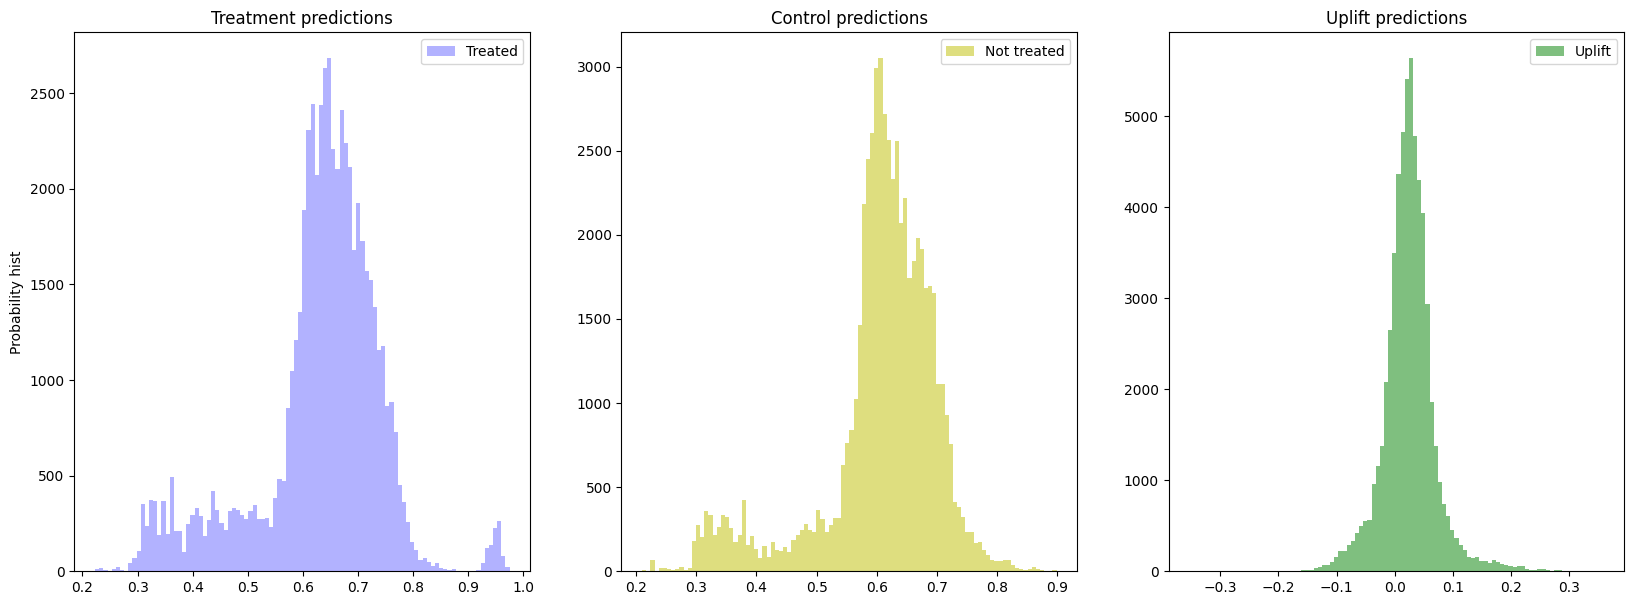

In [24]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

Посмотрим на результаты

In [ ]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
0,SoloModel,0.057262
1,ClassTransformation,0.053981
2,TwoModels,0.049310


#### Вариант с деревом решений

In [ ]:
X_train_tree = pd.concat([X_train.drop('gender', 1), 
                          pd.get_dummies(X_train['gender'], prefix='gender')], 1)
features = [col for col in X_train_tree]

In [70]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

ModuleNotFoundError: ignored

### Домашнее задание

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [4]:
import numpy as np
import pandas as pd

In [42]:
DT = pd.read_csv('HW_data.csv')

In [43]:
DT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [44]:
cat_features = ['zip_code', 'channel']

In [27]:
DT['channel'].unique()

array(['Phone', 'Web', 'Multichannel'], dtype=object)

In [28]:
DT = pd.get_dummies(DT, columns=['zip_code', 'channel'], prefix=['zip_code', 'channel'], dtype=float)

In [29]:
DT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   recency               64000 non-null  int64  
 1   history               64000 non-null  float64
 2   used_discount         64000 non-null  int64  
 3   used_bogo             64000 non-null  int64  
 4   is_referral           64000 non-null  int64  
 5   offer                 64000 non-null  object 
 6   conversion            64000 non-null  int64  
 7   zip_code_Rural        64000 non-null  float64
 8   zip_code_Surburban    64000 non-null  float64
 9   zip_code_Urban        64000 non-null  float64
 10  channel_Multichannel  64000 non-null  float64
 11  channel_Phone         64000 non-null  float64
 12  channel_Web           64000 non-null  float64
dtypes: float64(7), int64(5), object(1)
memory usage: 6.3+ MB


In [45]:
DT.rename(columns={'offer':'treatment','conversion':'target'}, inplace=True)

In [46]:
DT['treatment'] = np.where(DT['treatment'] == 'No Offer', 0, 1)

In [47]:
DT.groupby(by='treatment')['target'].count()

treatment
0    21306
1    42694
Name: target, dtype: int64

In [13]:
import seaborn as sns

In [14]:
sns.pairplot( # матрица диаграмм рассеяния из Seaborn
data = DT, # данные
hue = 'target', # имя столбца в данных для раскраски меток
corner = True # матрица симметрична, не будем выводить лишние графики
).fig.suptitle( # настройки заголовка
'Зависимости для признаков', # заголовок
y = 1.08 # расположение
);

KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f3086d17940> (for post_execute):


KeyboardInterrupt: ignored

In [48]:
X_train, X_val = train_test_split(DT, random_state=42, test_size=0.3)

In [49]:
X_train_feat = X_train.drop(labels=['treatment', 'target'], axis=1)
y_train = X_train['target']
X_train_treat = X_train['treatment']

X_val_feat = X_val.drop(labels=['treatment', 'target'], axis=1)
y_val = X_val['target']
X_val_treat = X_val['treatment']

models_results = {
    'approach': [],
    'uplift@20%': [],
    'uplift@10%': []
}

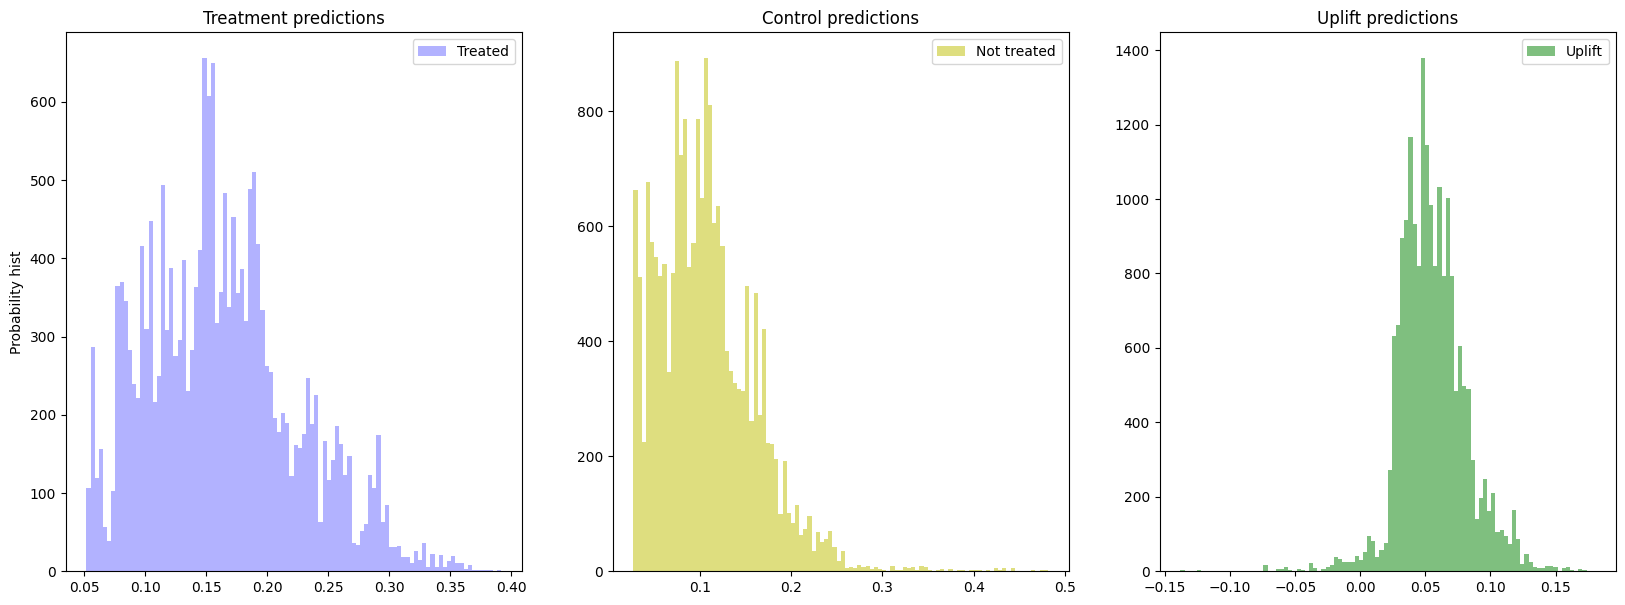

In [52]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train_feat, y_train, X_train_treat, estimator_fit_params={'cat_features':cat_features})

uplift_sm = sm.predict(X_val_feat)

sm_score_01 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=X_val_treat, strategy='by_group', k=0.1)
sm_score_02 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=X_val_treat, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_01)
models_results['uplift@20%'].append(sm_score_02)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [54]:
from sklift.models import ClassTransformation
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train_feat, y_train, X_train_treat, estimator_fit_params={'cat_features':cat_features})

uplift_ct = ct.predict(X_val_feat)

ct_score_01 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=X_val_treat, strategy='by_group', k=0.1)
ct_score_02 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=X_val_treat, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_01)
models_results['uplift@20%'].append(ct_score_02)

array([<Axes: title={'center': 'Treatment predictions'}, ylabel='Probability hist'>,
       <Axes: title={'center': 'Control predictions'}>,
       <Axes: title={'center': 'Uplift predictions'}>], dtype=object)

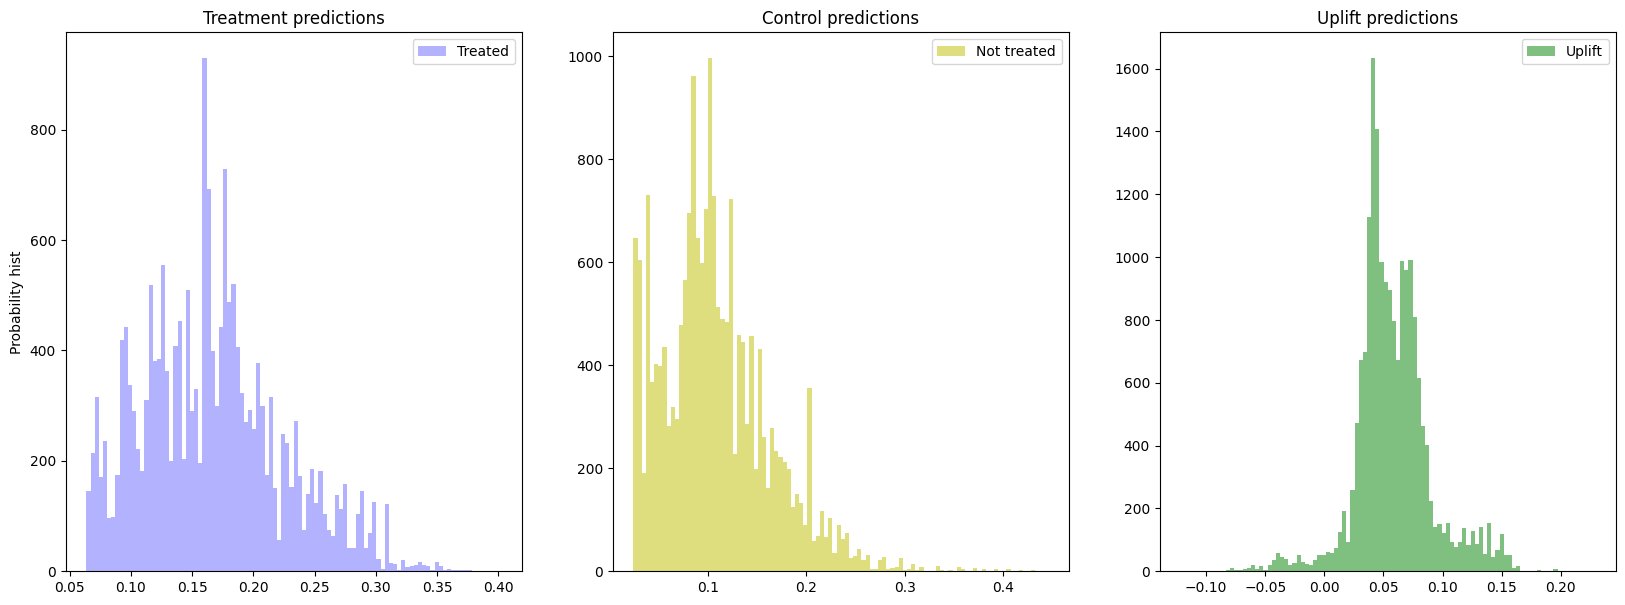

In [56]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train_feat, y_train, X_train_treat,
    estimator_trmnt_fit_params={'cat_features':cat_features},
    estimator_ctrl_fit_params={'cat_features':cat_features}
)

uplift_tm = tm.predict(X_val_feat)

tm_score_01 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=X_val_treat, strategy='by_group', k=0.1)
tm_score_02 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=X_val_treat, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_01)
models_results['uplift@20%'].append(tm_score_02)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_)

In [41]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@20%,uplift@10%
0,SoloModel,0.094320,0.113422
1,ClassTransformation,0.095181,0.101838
2,TwoModels,0.081051,0.083775


In [57]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@20%,uplift@10%
0,SoloModel,0.100633,0.122913
1,ClassTransformation,0.103868,0.119108
2,ClassTransformation,0.103868,0.119108
3,TwoModels,0.091545,0.109515


In [64]:
from sklift.viz import plot_uplift_curve

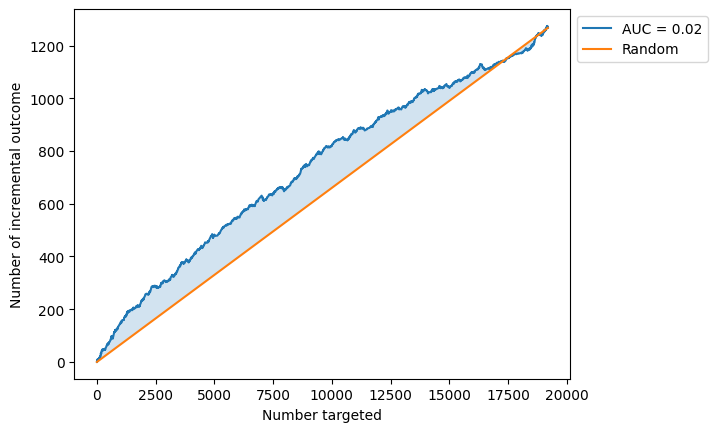

In [65]:
plot_uplift_curve(y_val, uplift_sm, X_val_treat, perfect=False)

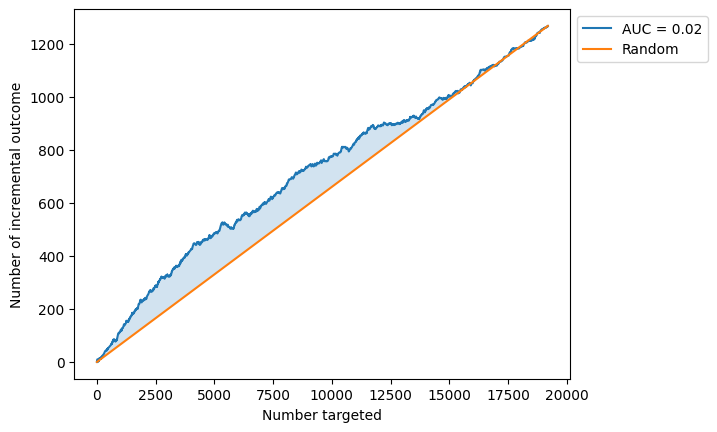

In [66]:
plot_uplift_curve(y_val, uplift_ct, X_val_treat, perfect=False)

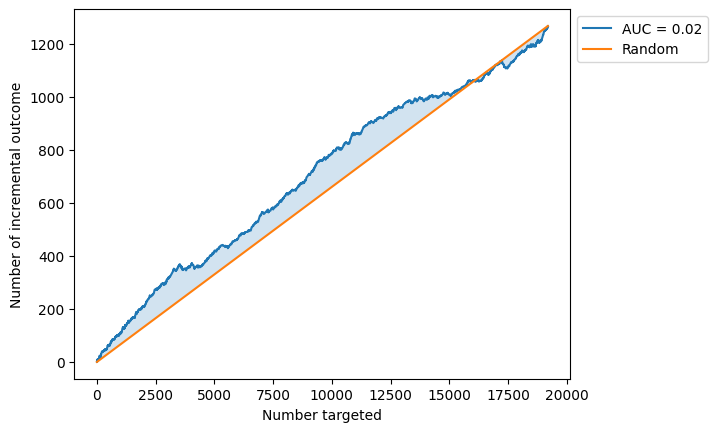

In [67]:
plot_uplift_curve(y_val, uplift_tm, X_val_treat, perfect=False)

### Ссылки

1. https://towardsdatascience.com/a-quick-uplift-modeling-introduction-6e14de32bfe0
2. https://habr.com/ru/company/ru_mts/blog/485980/#reference1
3. https://en.wikipedia.org/wiki/Uplift_modelling
4. https://www.youtube.com/watch?v=yFQAIJBYXI0
5. https://www.youtube.com/watch?v=jCUcYiBK03I
6. https://www.uplift-modeling.com/en/latest/
7. https://arxiv.org/pdf/1809.04559.pdf
8. https://catboost.ai/docs/concepts/about.html

### Библиотеки и пакеты

1. causalml
2. sklift
3. catboost
4. causalml

In [18]:
!pip install scikit-uplift

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 KB 4.3 MB/s eta 0:00:00


In [19]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.0 MB/s eta 0:00:00


In [69]:
# !git clone https://github.com/uber/causalml.git
# !pip install -r causalml/requirements.txt
# !pip install causalml

Cloning into 'causalml'...
remote: Enumerating objects: 3469, done.
remote: Counting objects: 100% (341/341), done.
remote: Compressing objects: 100% (197/197), done.
remote: Total 3469 (delta 202), reused 253 (delta 144), pack-reused 3128
Receiving objects: 100% (3469/3469), 61.85 MiB | 16.10 MiB/s, done.
Resolving deltas: 100% (2145/2145), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.2/522.2 KB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 KB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 15.1 MB